In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
np.random.seed(0)

In [3]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
errors = np.sqrt(np.abs(np.diagonal(syscov)))

### Generate a data set with covariance matrix from the original plus gaussian noise

In [4]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.001 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 1000 matrix 

In [5]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))


(1000, 31, 31)


In [6]:
from astroNN.nn.layers import MCDropout

In [7]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))
# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.1)(encoded2)
#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.1)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)               

In [8]:
autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=2000,                                    
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test))
#                     callbacks=callbacks)

Epoch 1/2000
25/25 [==============================] - 0s 9ms/step - loss: 3.1837e-06 - val_loss: 1.9292e-06
Epoch 2/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.6473e-06 - val_loss: 1.4711e-06
Epoch 3/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.4896e-06 - val_loss: 1.4833e-06
Epoch 4/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.5048e-06 - val_loss: 1.5472e-06
Epoch 5/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.4999e-06 - val_loss: 1.5584e-06
Epoch 6/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.4731e-06 - val_loss: 1.4426e-06
Epoch 7/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.4426e-06 - val_loss: 1.4935e-06
Epoch 8/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.4257e-06 - val_loss: 1.3958e-06
Epoch 9/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.3983e-06 - val_loss: 1.4276e-06
Epoch 10/2000
25/25 [=======

25/25 [==============================] - 0s 3ms/step - loss: 1.1172e-06 - val_loss: 1.1286e-06
Epoch 77/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.1080e-06 - val_loss: 1.1276e-06
Epoch 78/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.1100e-06 - val_loss: 1.1316e-06
Epoch 79/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.1105e-06 - val_loss: 1.1264e-06
Epoch 80/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.1107e-06 - val_loss: 1.1347e-06
Epoch 81/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.1077e-06 - val_loss: 1.1255e-06
Epoch 82/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.1071e-06 - val_loss: 1.1228e-06
Epoch 83/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.1057e-06 - val_loss: 1.1208e-06
Epoch 84/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.1032e-06 - val_loss: 1.1232e-06
Epoch 85/2000
25/25 [============

Epoch 151/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0790e-06 - val_loss: 1.0957e-06
Epoch 152/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0830e-06 - val_loss: 1.1046e-06
Epoch 153/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0837e-06 - val_loss: 1.1056e-06
Epoch 154/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0841e-06 - val_loss: 1.0957e-06
Epoch 155/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0794e-06 - val_loss: 1.0943e-06
Epoch 156/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0811e-06 - val_loss: 1.0933e-06
Epoch 157/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0816e-06 - val_loss: 1.0952e-06
Epoch 158/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0843e-06 - val_loss: 1.1017e-06
Epoch 159/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0861e-06 - val_loss: 1.0993e-06
Epoch 160/

25/25 [==============================] - 0s 2ms/step - loss: 1.0725e-06 - val_loss: 1.0918e-06
Epoch 226/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0733e-06 - val_loss: 1.0780e-06
Epoch 227/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0707e-06 - val_loss: 1.0877e-06
Epoch 228/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0762e-06 - val_loss: 1.0872e-06
Epoch 229/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0750e-06 - val_loss: 1.0928e-06
Epoch 230/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0713e-06 - val_loss: 1.0783e-06
Epoch 231/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0725e-06 - val_loss: 1.0880e-06
Epoch 232/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0703e-06 - val_loss: 1.0959e-06
Epoch 233/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0754e-06 - val_loss: 1.0873e-06
Epoch 234/2000
25/25 [===

25/25 [==============================] - 0s 2ms/step - loss: 1.0666e-06 - val_loss: 1.0843e-06
Epoch 300/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0651e-06 - val_loss: 1.0781e-06
Epoch 301/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0689e-06 - val_loss: 1.0885e-06
Epoch 302/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0725e-06 - val_loss: 1.0862e-06
Epoch 303/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0694e-06 - val_loss: 1.0858e-06
Epoch 304/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0674e-06 - val_loss: 1.0815e-06
Epoch 305/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0686e-06 - val_loss: 1.0804e-06
Epoch 306/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0698e-06 - val_loss: 1.0827e-06
Epoch 307/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0692e-06 - val_loss: 1.0779e-06
Epoch 308/2000
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0668e-06 - val_loss: 1.0860e-06
Epoch 374/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0675e-06 - val_loss: 1.0776e-06
Epoch 375/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0646e-06 - val_loss: 1.0794e-06
Epoch 376/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0600e-06 - val_loss: 1.0782e-06
Epoch 377/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0653e-06 - val_loss: 1.0782e-06
Epoch 378/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0633e-06 - val_loss: 1.0679e-06
Epoch 379/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0622e-06 - val_loss: 1.0753e-06
Epoch 380/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0631e-06 - val_loss: 1.0744e-06
Epoch 381/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0640e-06 - val_loss: 1.0840e-06
Epoch 382/2000
25/25 [===

25/25 [==============================] - 0s 2ms/step - loss: 1.0662e-06 - val_loss: 1.0777e-06
Epoch 448/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0621e-06 - val_loss: 1.0784e-06
Epoch 449/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0610e-06 - val_loss: 1.0730e-06
Epoch 450/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0634e-06 - val_loss: 1.0757e-06
Epoch 451/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0646e-06 - val_loss: 1.0763e-06
Epoch 452/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0631e-06 - val_loss: 1.0719e-06
Epoch 453/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0635e-06 - val_loss: 1.0761e-06
Epoch 454/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0672e-06 - val_loss: 1.0820e-06
Epoch 455/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0609e-06 - val_loss: 1.0737e-06
Epoch 456/2000
25/25 [===

25/25 [==============================] - 0s 6ms/step - loss: 1.0600e-06 - val_loss: 1.0766e-06
Epoch 522/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0599e-06 - val_loss: 1.0734e-06
Epoch 523/2000
25/25 [==============================] - 0s 5ms/step - loss: 1.0600e-06 - val_loss: 1.0739e-06
Epoch 524/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0593e-06 - val_loss: 1.0742e-06
Epoch 525/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0586e-06 - val_loss: 1.0756e-06
Epoch 526/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0571e-06 - val_loss: 1.0663e-06
Epoch 527/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0617e-06 - val_loss: 1.0737e-06
Epoch 528/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0618e-06 - val_loss: 1.0746e-06
Epoch 529/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0576e-06 - val_loss: 1.0736e-06
Epoch 530/2000
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0593e-06 - val_loss: 1.0731e-06
Epoch 596/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0581e-06 - val_loss: 1.0697e-06
Epoch 597/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0557e-06 - val_loss: 1.0736e-06
Epoch 598/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0605e-06 - val_loss: 1.0717e-06
Epoch 599/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0629e-06 - val_loss: 1.0798e-06
Epoch 600/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0592e-06 - val_loss: 1.0654e-06
Epoch 601/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0583e-06 - val_loss: 1.0720e-06
Epoch 602/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0618e-06 - val_loss: 1.0743e-06
Epoch 603/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0605e-06 - val_loss: 1.0684e-06
Epoch 604/2000
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0564e-06 - val_loss: 1.0619e-06
Epoch 670/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0563e-06 - val_loss: 1.0701e-06
Epoch 671/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0570e-06 - val_loss: 1.0824e-06
Epoch 672/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0607e-06 - val_loss: 1.0670e-06
Epoch 673/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0563e-06 - val_loss: 1.0718e-06
Epoch 674/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0605e-06 - val_loss: 1.0761e-06
Epoch 675/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0603e-06 - val_loss: 1.0790e-06
Epoch 676/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0587e-06 - val_loss: 1.0716e-06
Epoch 677/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0580e-06 - val_loss: 1.0669e-06
Epoch 678/2000
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0579e-06 - val_loss: 1.0651e-06
Epoch 744/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0577e-06 - val_loss: 1.0684e-06
Epoch 745/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0562e-06 - val_loss: 1.0721e-06
Epoch 746/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0557e-06 - val_loss: 1.0696e-06
Epoch 747/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0561e-06 - val_loss: 1.0656e-06
Epoch 748/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0588e-06 - val_loss: 1.0724e-06
Epoch 749/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0582e-06 - val_loss: 1.0714e-06
Epoch 750/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0529e-06 - val_loss: 1.0647e-06
Epoch 751/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0543e-06 - val_loss: 1.0714e-06
Epoch 752/2000
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0577e-06 - val_loss: 1.0657e-06
Epoch 818/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0568e-06 - val_loss: 1.0670e-06
Epoch 819/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0579e-06 - val_loss: 1.0669e-06
Epoch 820/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0603e-06 - val_loss: 1.0763e-06
Epoch 821/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0620e-06 - val_loss: 1.0827e-06
Epoch 822/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0602e-06 - val_loss: 1.0713e-06
Epoch 823/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0541e-06 - val_loss: 1.0667e-06
Epoch 824/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0544e-06 - val_loss: 1.0627e-06
Epoch 825/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0566e-06 - val_loss: 1.0707e-06
Epoch 826/2000
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0567e-06 - val_loss: 1.0692e-06
Epoch 892/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0565e-06 - val_loss: 1.0800e-06
Epoch 893/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0596e-06 - val_loss: 1.0709e-06
Epoch 894/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0556e-06 - val_loss: 1.0697e-06
Epoch 895/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0533e-06 - val_loss: 1.0678e-06
Epoch 896/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0563e-06 - val_loss: 1.0743e-06
Epoch 897/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0561e-06 - val_loss: 1.0637e-06
Epoch 898/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0544e-06 - val_loss: 1.0684e-06
Epoch 899/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0569e-06 - val_loss: 1.0697e-06
Epoch 900/2000
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0546e-06 - val_loss: 1.0665e-06
Epoch 966/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0516e-06 - val_loss: 1.0699e-06
Epoch 967/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0537e-06 - val_loss: 1.0741e-06
Epoch 968/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0556e-06 - val_loss: 1.0596e-06
Epoch 969/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0499e-06 - val_loss: 1.0628e-06
Epoch 970/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0516e-06 - val_loss: 1.0662e-06
Epoch 971/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0533e-06 - val_loss: 1.0739e-06
Epoch 972/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0599e-06 - val_loss: 1.0740e-06
Epoch 973/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0575e-06 - val_loss: 1.0682e-06
Epoch 974/2000
25/25 [===

25/25 [==============================] - 0s 3ms/step - loss: 1.0520e-06 - val_loss: 1.0653e-06
Epoch 1040/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0505e-06 - val_loss: 1.0645e-06
Epoch 1041/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0523e-06 - val_loss: 1.0619e-06
Epoch 1042/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0541e-06 - val_loss: 1.0687e-06
Epoch 1043/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0529e-06 - val_loss: 1.0670e-06
Epoch 1044/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0506e-06 - val_loss: 1.0622e-06
Epoch 1045/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0547e-06 - val_loss: 1.0671e-06
Epoch 1046/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0544e-06 - val_loss: 1.0698e-06
Epoch 1047/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0536e-06 - val_loss: 1.0654e-06
Epoch 1048/2000
2

Epoch 1113/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0521e-06 - val_loss: 1.0679e-06
Epoch 1114/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0518e-06 - val_loss: 1.0628e-06
Epoch 1115/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0523e-06 - val_loss: 1.0600e-06
Epoch 1116/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0520e-06 - val_loss: 1.0645e-06
Epoch 1117/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0535e-06 - val_loss: 1.0644e-06
Epoch 1118/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0510e-06 - val_loss: 1.0678e-06
Epoch 1119/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0497e-06 - val_loss: 1.0714e-06
Epoch 1120/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0523e-06 - val_loss: 1.0617e-06
Epoch 1121/2000
25/25 [==============================] - 0s 5ms/step - loss: 1.0512e-06 - val_loss: 1.0661e-06
E

Epoch 1187/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0492e-06 - val_loss: 1.0646e-06
Epoch 1188/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0486e-06 - val_loss: 1.0660e-06
Epoch 1189/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0498e-06 - val_loss: 1.0632e-06
Epoch 1190/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0509e-06 - val_loss: 1.0601e-06
Epoch 1191/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0487e-06 - val_loss: 1.0637e-06
Epoch 1192/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0512e-06 - val_loss: 1.0713e-06
Epoch 1193/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0518e-06 - val_loss: 1.0669e-06
Epoch 1194/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0514e-06 - val_loss: 1.0662e-06
Epoch 1195/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0501e-06 - val_loss: 1.0614e-06
E

Epoch 1261/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0481e-06 - val_loss: 1.0624e-06
Epoch 1262/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0498e-06 - val_loss: 1.0694e-06
Epoch 1263/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0502e-06 - val_loss: 1.0715e-06
Epoch 1264/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0508e-06 - val_loss: 1.0641e-06
Epoch 1265/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0503e-06 - val_loss: 1.0579e-06
Epoch 1266/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0517e-06 - val_loss: 1.0678e-06
Epoch 1267/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0502e-06 - val_loss: 1.0695e-06
Epoch 1268/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0492e-06 - val_loss: 1.0657e-06
Epoch 1269/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0495e-06 - val_loss: 1.0630e-06
E

Epoch 1335/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0484e-06 - val_loss: 1.0640e-06
Epoch 1336/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0470e-06 - val_loss: 1.0695e-06
Epoch 1337/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0516e-06 - val_loss: 1.0675e-06
Epoch 1338/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0496e-06 - val_loss: 1.0708e-06
Epoch 1339/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0474e-06 - val_loss: 1.0673e-06
Epoch 1340/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0492e-06 - val_loss: 1.0656e-06
Epoch 1341/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0468e-06 - val_loss: 1.0660e-06
Epoch 1342/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0489e-06 - val_loss: 1.0699e-06
Epoch 1343/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0478e-06 - val_loss: 1.0608e-06
E

Epoch 1409/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0484e-06 - val_loss: 1.0633e-06
Epoch 1410/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0472e-06 - val_loss: 1.0715e-06
Epoch 1411/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0465e-06 - val_loss: 1.0666e-06
Epoch 1412/2000
25/25 [==============================] - ETA: 0s - loss: 1.0484e-0 - 0s 3ms/step - loss: 1.0479e-06 - val_loss: 1.0612e-06
Epoch 1413/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0496e-06 - val_loss: 1.0679e-06
Epoch 1414/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0483e-06 - val_loss: 1.0646e-06
Epoch 1415/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0479e-06 - val_loss: 1.0631e-06
Epoch 1416/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0469e-06 - val_loss: 1.0697e-06
Epoch 1417/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0487e

25/25 [==============================] - 0s 3ms/step - loss: 1.0479e-06 - val_loss: 1.0619e-06
Epoch 1483/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0479e-06 - val_loss: 1.0681e-06
Epoch 1484/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0523e-06 - val_loss: 1.0706e-06
Epoch 1485/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0499e-06 - val_loss: 1.0649e-06
Epoch 1486/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0481e-06 - val_loss: 1.0624e-06
Epoch 1487/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0475e-06 - val_loss: 1.0645e-06
Epoch 1488/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0435e-06 - val_loss: 1.0608e-06
Epoch 1489/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0431e-06 - val_loss: 1.0646e-06
Epoch 1490/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0490e-06 - val_loss: 1.0635e-06
Epoch 1491/2000
2

Epoch 1556/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0450e-06 - val_loss: 1.0671e-06
Epoch 1557/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0479e-06 - val_loss: 1.0680e-06
Epoch 1558/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0477e-06 - val_loss: 1.0657e-06
Epoch 1559/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0462e-06 - val_loss: 1.0635e-06
Epoch 1560/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0472e-06 - val_loss: 1.0665e-06
Epoch 1561/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0454e-06 - val_loss: 1.0645e-06
Epoch 1562/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0462e-06 - val_loss: 1.0624e-06
Epoch 1563/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0498e-06 - val_loss: 1.0702e-06
Epoch 1564/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0480e-06 - val_loss: 1.0704e-06
E

Epoch 1630/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0463e-06 - val_loss: 1.0636e-06
Epoch 1631/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0465e-06 - val_loss: 1.0656e-06
Epoch 1632/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0466e-06 - val_loss: 1.0699e-06
Epoch 1633/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0485e-06 - val_loss: 1.0665e-06
Epoch 1634/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0437e-06 - val_loss: 1.0637e-06
Epoch 1635/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0458e-06 - val_loss: 1.0700e-06
Epoch 1636/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0458e-06 - val_loss: 1.0693e-06
Epoch 1637/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0458e-06 - val_loss: 1.0641e-06
Epoch 1638/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0456e-06 - val_loss: 1.0636e-06
E

Epoch 1704/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0460e-06 - val_loss: 1.0683e-06
Epoch 1705/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0429e-06 - val_loss: 1.0633e-06
Epoch 1706/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0433e-06 - val_loss: 1.0624e-06
Epoch 1707/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0443e-06 - val_loss: 1.0642e-06
Epoch 1708/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0444e-06 - val_loss: 1.0658e-06
Epoch 1709/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0454e-06 - val_loss: 1.0692e-06
Epoch 1710/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0450e-06 - val_loss: 1.0611e-06
Epoch 1711/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0448e-06 - val_loss: 1.0638e-06
Epoch 1712/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0432e-06 - val_loss: 1.0683e-06
E

Epoch 1778/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0427e-06 - val_loss: 1.0647e-06
Epoch 1779/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0436e-06 - val_loss: 1.0657e-06
Epoch 1780/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0443e-06 - val_loss: 1.0622e-06
Epoch 1781/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0431e-06 - val_loss: 1.0648e-06
Epoch 1782/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0438e-06 - val_loss: 1.0639e-06
Epoch 1783/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0465e-06 - val_loss: 1.0677e-06
Epoch 1784/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0431e-06 - val_loss: 1.0620e-06
Epoch 1785/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0430e-06 - val_loss: 1.0727e-06
Epoch 1786/2000
25/25 [==============================] - 0s 2ms/step - loss: 1.0434e-06 - val_loss: 1.0646e-06
E

Epoch 1852/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0406e-06 - val_loss: 1.0664e-06
Epoch 1853/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0467e-06 - val_loss: 1.0709e-06
Epoch 1854/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0468e-06 - val_loss: 1.0656e-06
Epoch 1855/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0422e-06 - val_loss: 1.0623e-06
Epoch 1856/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0396e-06 - val_loss: 1.0674e-06
Epoch 1857/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0453e-06 - val_loss: 1.0678e-06
Epoch 1858/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0448e-06 - val_loss: 1.0635e-06
Epoch 1859/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0417e-06 - val_loss: 1.0627e-06
Epoch 1860/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0390e-06 - val_loss: 1.0571e-06
E

Epoch 1926/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0410e-06 - val_loss: 1.0619e-06
Epoch 1927/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0401e-06 - val_loss: 1.0614e-06
Epoch 1928/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0384e-06 - val_loss: 1.0657e-06
Epoch 1929/2000
25/25 [==============================] - 0s 4ms/step - loss: 1.0389e-06 - val_loss: 1.0630e-06
Epoch 1930/2000
25/25 [==============================] - 0s 6ms/step - loss: 1.0403e-06 - val_loss: 1.0693e-06
Epoch 1931/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0397e-06 - val_loss: 1.0653e-06
Epoch 1932/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0428e-06 - val_loss: 1.0614e-06
Epoch 1933/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0434e-06 - val_loss: 1.0693e-06
Epoch 1934/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0413e-06 - val_loss: 1.0646e-06
E

Epoch 2000/2000
25/25 [==============================] - 0s 3ms/step - loss: 1.0394e-06 - val_loss: 1.0677e-06


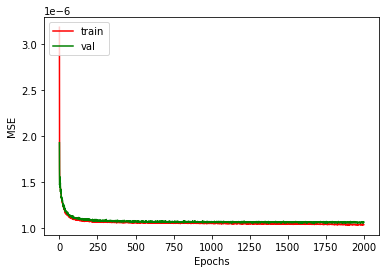

In [9]:
plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLAdropout.png', dpi=200)

In [10]:
encoder2 = tf.keras.Model(input_img2, encoded2)
# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [11]:
decoder2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3200      
_________________________________________________________________
MCDropout_4 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_5 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
________________________________________________

In [12]:
encoded_imgs = encoder2.predict(covset_test)
decoded_imgs = decoder2.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)


(200, 31)


In [13]:
fake_encoded = np.zeros((1, 31))
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)

(1, 31)


In [14]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0, dtype=np.float64)
std_mc_dropout_dec = np.std(predictions_dec, axis=0, dtype=np.float64)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

((1, 961), (1, 961))

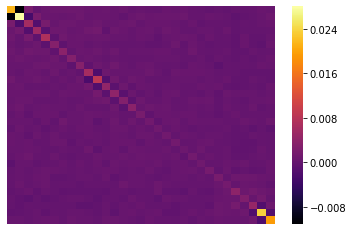

In [15]:
sns.heatmap(pd.DataFrame(prediction_mc_dropout_dec[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

# FFNN

In [16]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)

shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

z = data[:,0]
dl = data[:,1:]
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)



In [17]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.1)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.1)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
MCDropout_6 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
MCDropout_7 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
MCDropout_8 (MCDropout)      (None, 50)               

In [29]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=2,
                                    epochs=400,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/400
12/12 [==============================] - 0s 3ms/step - loss: 11.7178 - val_loss: 40.1792
Epoch 2/400
12/12 [==============================] - 0s 2ms/step - loss: 11.2942 - val_loss: 26.9557
Epoch 3/400
12/12 [==============================] - 0s 2ms/step - loss: 21.3908 - val_loss: 17.5252
Epoch 4/400
12/12 [==============================] - 0s 2ms/step - loss: 20.5577 - val_loss: 8.3484
Epoch 5/400
12/12 [==============================] - 0s 2ms/step - loss: 11.1615 - val_loss: 16.5059
Epoch 6/400
12/12 [==============================] - 0s 2ms/step - loss: 22.7770 - val_loss: 20.7580
Epoch 7/400
12/12 [==============================] - 0s 2ms/step - loss: 30.0672 - val_loss: 23.5035
Epoch 8/400
12/12 [==============================] - 0s 2ms/step - loss: 16.0479 - val_loss: 15.3672
Epoch 9/400
12/12 [==============================] - 0s 2ms/step - loss: 17.7998 - val_loss: 12.4299
Epoch 10/400
12/12 [==============================] - 0s 2ms/step - loss: 7.3490 - val_loss:

12/12 [==============================] - 0s 2ms/step - loss: 12.6744 - val_loss: 12.3309
Epoch 82/400
12/12 [==============================] - 0s 2ms/step - loss: 13.9042 - val_loss: 41.6920
Epoch 83/400
12/12 [==============================] - 0s 2ms/step - loss: 23.5973 - val_loss: 26.1277
Epoch 84/400
12/12 [==============================] - 0s 2ms/step - loss: 12.9331 - val_loss: 17.8931
Epoch 85/400
12/12 [==============================] - 0s 2ms/step - loss: 14.0803 - val_loss: 11.0038
Epoch 86/400
12/12 [==============================] - 0s 2ms/step - loss: 15.2360 - val_loss: 3.4253
Epoch 87/400
12/12 [==============================] - 0s 2ms/step - loss: 12.9565 - val_loss: 8.9406
Epoch 88/400
12/12 [==============================] - 0s 2ms/step - loss: 9.2433 - val_loss: 16.8558
Epoch 89/400
12/12 [==============================] - 0s 2ms/step - loss: 14.6363 - val_loss: 8.8055
Epoch 90/400
12/12 [==============================] - 0s 2ms/step - loss: 15.5865 - val_loss: 8.300

12/12 [==============================] - 0s 2ms/step - loss: 15.3559 - val_loss: 7.4414
Epoch 162/400
12/12 [==============================] - 0s 2ms/step - loss: 17.3676 - val_loss: 22.1900
Epoch 163/400
12/12 [==============================] - 0s 2ms/step - loss: 29.2870 - val_loss: 36.1099
Epoch 164/400
12/12 [==============================] - 0s 2ms/step - loss: 10.3718 - val_loss: 24.6239
Epoch 165/400
12/12 [==============================] - 0s 2ms/step - loss: 17.2759 - val_loss: 22.9934
Epoch 166/400
12/12 [==============================] - 0s 2ms/step - loss: 18.9052 - val_loss: 2.2037
Epoch 167/400
12/12 [==============================] - 0s 2ms/step - loss: 14.1282 - val_loss: 12.0370
Epoch 168/400
12/12 [==============================] - 0s 2ms/step - loss: 17.3643 - val_loss: 10.8324
Epoch 169/400
12/12 [==============================] - 0s 2ms/step - loss: 9.9057 - val_loss: 7.1948
Epoch 170/400
12/12 [==============================] - 0s 2ms/step - loss: 11.3961 - val_lo

12/12 [==============================] - 0s 2ms/step - loss: 24.1652 - val_loss: 7.4362
Epoch 242/400
12/12 [==============================] - 0s 2ms/step - loss: 9.3089 - val_loss: 8.3030
Epoch 243/400
12/12 [==============================] - 0s 2ms/step - loss: 9.4511 - val_loss: 16.8640
Epoch 244/400
12/12 [==============================] - 0s 2ms/step - loss: 11.2156 - val_loss: 16.3014
Epoch 245/400
12/12 [==============================] - 0s 2ms/step - loss: 10.5960 - val_loss: 9.5470
Epoch 246/400
12/12 [==============================] - 0s 2ms/step - loss: 15.2101 - val_loss: 20.9141
Epoch 247/400
12/12 [==============================] - 0s 2ms/step - loss: 18.4846 - val_loss: 6.3293
Epoch 248/400
12/12 [==============================] - 0s 2ms/step - loss: 13.8525 - val_loss: 5.5875
Epoch 249/400
12/12 [==============================] - 0s 2ms/step - loss: 14.3221 - val_loss: 6.3981
Epoch 250/400
12/12 [==============================] - 0s 2ms/step - loss: 16.1184 - val_loss: 

12/12 [==============================] - 0s 2ms/step - loss: 9.6274 - val_loss: 12.7184
Epoch 322/400
12/12 [==============================] - 0s 2ms/step - loss: 16.1580 - val_loss: 6.5577
Epoch 323/400
12/12 [==============================] - 0s 2ms/step - loss: 14.8975 - val_loss: 23.5422
Epoch 324/400
12/12 [==============================] - 0s 2ms/step - loss: 16.0581 - val_loss: 10.7361
Epoch 325/400
12/12 [==============================] - 0s 2ms/step - loss: 12.3838 - val_loss: 19.0690
Epoch 326/400
12/12 [==============================] - 0s 2ms/step - loss: 9.1119 - val_loss: 24.1441
Epoch 327/400
12/12 [==============================] - 0s 2ms/step - loss: 14.3888 - val_loss: 15.4542
Epoch 328/400
12/12 [==============================] - 0s 2ms/step - loss: 12.6289 - val_loss: 21.0911
Epoch 329/400
12/12 [==============================] - 0s 2ms/step - loss: 13.7155 - val_loss: 23.6186
Epoch 330/400
12/12 [==============================] - 0s 2ms/step - loss: 12.9434 - val_l

In [30]:
# Generate test data
# test_batch_size = 31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)
# Generate test data
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)



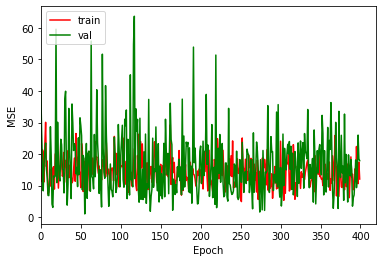

In [31]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_dropoutJLA.png', dpi=100)

In [32]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z), 31)
ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model2.predict(ranzz)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$

(31,)
(200, 31)
<class 'numpy.ndarray'>


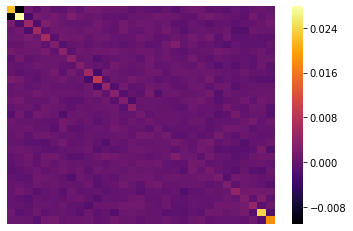

In [33]:
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))
print(type(encoded_imgs))
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]
decoded_fake = decoder2.predict(fake_encoded)
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
sns.heatmap(pd.DataFrame(decoded_fake.reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [34]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [35]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

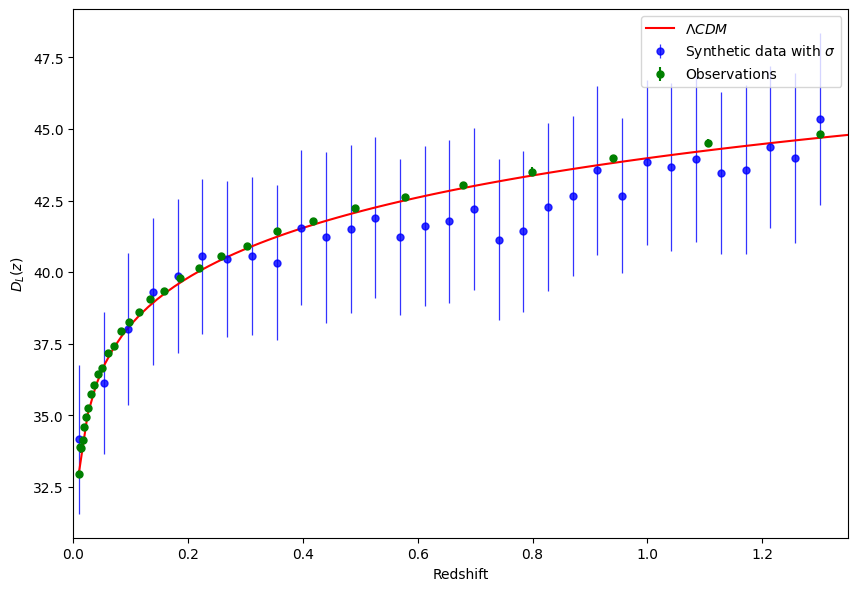

In [36]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

# std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))
std_dropout_diag = np.diagonal(std_mc_dropout_dec.reshape(31,31))

# sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 + std_dropout_diag)
sigma = np.sqrt(std_mc_dropout.reshape(31,) + fakeerrors2 **2 + std_dropout_diag)

plt.errorbar(ranz, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift')
plt.ylabel('$D_L(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=200)

In [37]:
matrix_with_all_err = prediction_mc_dropout_dec[0, :].reshape(31,31)
np.fill_diagonal(matrix_with_all_err, sigma**2)

In [38]:
np.savetxt("fake_binned_JLA_COVdecodedDO2.dat", prediction_mc_dropout_dec[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO2.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [39]:
# autoencoder2.save('autoencoderJLA_DO.h5')
# decoder2.save('decoderJLA_DO.h5')
# neural_model2.save('FFNN_JLA_DO.h5')
# encoder2.save('encoderJLA_DO.h5')